<p style="font-size: 22pt; color: green; font-family: 'Times New Roman';">
 Import Modules necessary for running this notebook 
</p>

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

<hr style="border: none; height: 2px; background-color: blue; border-style: dotted;">
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Read Data:: <span style="font-size: 13pt; color: black;"> FACTS 1.1.1</span>
</span>


In [2]:
path = os.path.expanduser(f'~/werk.M2/0000_facts-OPdata.M2/amarel/ar2208/factsv1.1.1/coupling.ssp245/output/')

# !-----------------------------------------------------------------!
# Yaxis (fixed ; NYC RSL 2100)
dat2='coupling.ssp245.total.workflow.wf2f.local.nc' 
# !---!
# Xaxis (Vary ; 2030component)
dat1='coupling.ssp245.total.workflow.wf2f.local.nc'
# dat1='coupling.ssp245.total.workflow.wf2f.global.nc'
# !-----------------------------------------------------------------!

var1 = xr.open_dataset(f'{path}{dat1}', engine='netcdf4')
var2 = xr.open_dataset(f'{path}{dat2}', engine='netcdf4')

xaxVAR=var1['sea_level_change'][:, np.where(var1['years']==2030)[0][0]]
yaxVAR=var2['sea_level_change'][:, np.where(var2['years']==2100)[0][0]] 

# convert to cm
xaxVAR=xaxVAR/10
yaxVAR=yaxVAR/10

INdata = np.column_stack((xaxVAR, yaxVAR))

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: raw data / samples
</span>


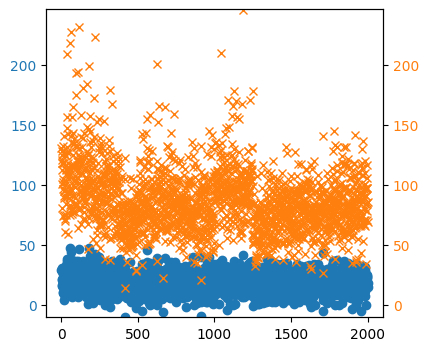

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

ax=axs[0]
numbers = np.linspace(1, 2000, 2000)    
x_min, x_max = np.floor(np.min(numbers)), np.ceil(np.max(numbers)) 
#
color = 'tab:blue'
ax.set_xlabel('')
ax.set_ylabel('', color=color)
ax.plot(numbers,INdata[:, 0], 'o', linestyle='none', color=color)
ax.tick_params(axis='y', labelcolor=color)
#
ax2 = ax.twinx()  
color = 'tab:orange'
ax2.set_ylabel('', color=color)
ax2.plot(numbers,INdata[:, 1], 'x', linestyle='none', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax.set_ylim(-10, np.ceil(np.max(INdata[:, 1])))
ax2.set_ylim(-10, np.ceil(np.max(INdata[:, 1])))

for i in [1, 2, 3]: axs[i].set_visible(False)

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: Scatter
</span>

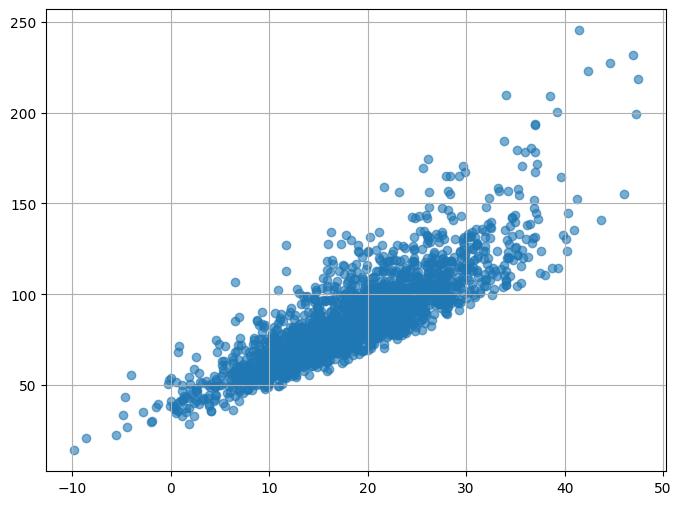

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(INdata[:, 0], INdata[:, 1], alpha=0.6)
plt.grid(True)
plt.show()

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: KDE
</span>

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

data = INdata
#print("Data shape:", data.shape)

# Grid of bandwidth values to test
bandwidths = np.linspace(0.1, 10, 40)  
# Setup the grid search with cross-validation
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   {'bandwidth': bandwidths},
                   cv=5)  # 5-fold cross-validation
# Fit grid search
grid.fit(data)
# Best bandwidth
best_bw = np.round(grid.best_params_['bandwidth'],2)
print("Optimal bandwidth:", best_bw)
bw_kde=best_bw

Optimal bandwidth: 2.64


In [6]:
kde = KernelDensity(kernel='gaussian', bandwidth=bw_kde).fit(INdata)

In [7]:
xgrid = np.linspace(INdata[:,0].min()-1, INdata[:,0].max()+1, 100)  
ygrid = np.linspace(INdata[:,1].min()-1, INdata[:,1].max()+1, 100)

Xgrid, Ygrid  = np.meshgrid(xgrid, ygrid)
grid_samples = np.vstack([Xgrid.ravel(), Ygrid.ravel()]).T
#
# Eval density model on the grid (log likelihoods)
log_density_values = kde.score_samples(grid_samples)
#Reshape 
log_density_values = log_density_values.reshape(Xgrid.shape)
#
#-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
# Density values
density_values = np.exp(log_density_values)
#.............................................................................................................
# Normalize 
normalized_density_values = density_values / np.sum(density_values, axis=0);

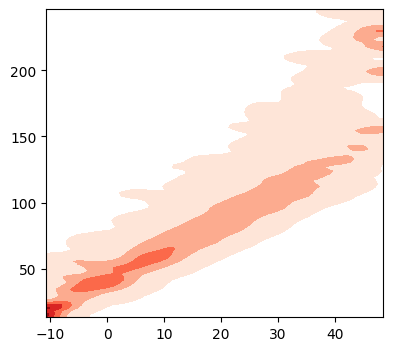

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
ax=axs[0]

clevels=np.linspace(0.001,0.2,6)
clabels=np.round(clevels,decimals=3).astype('str')
contour=ax.contourf(Xgrid, Ygrid, normalized_density_values,levels=clevels,cmap='Reds')

for i in [1, 2, 3]: axs[i].set_visible(False)

(0.999, 1.001)

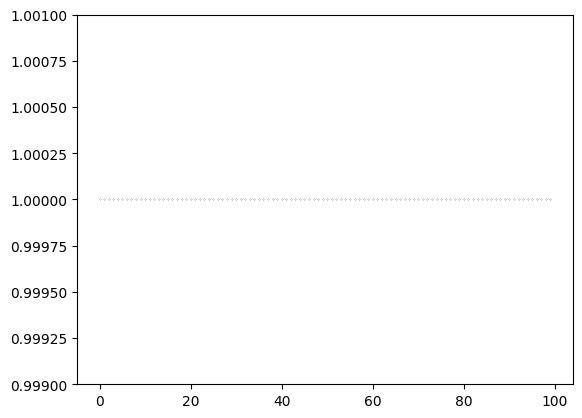

In [9]:
column_sums = np.sum(normalized_density_values, axis=0)
plt.plot(column_sums,'.',markersize=.25,color='black')
plt.ylim(0.999, 1.001)

<hr style="position: absolute; left: 1.5; width: 50%; height: 2px; background-color: blue; border-style: solid;"><br>
<span style="font-family: 'Times New Roman'; font-size: 16pt; color: blue;">
    Plot:: Conditional Probability 
</span>


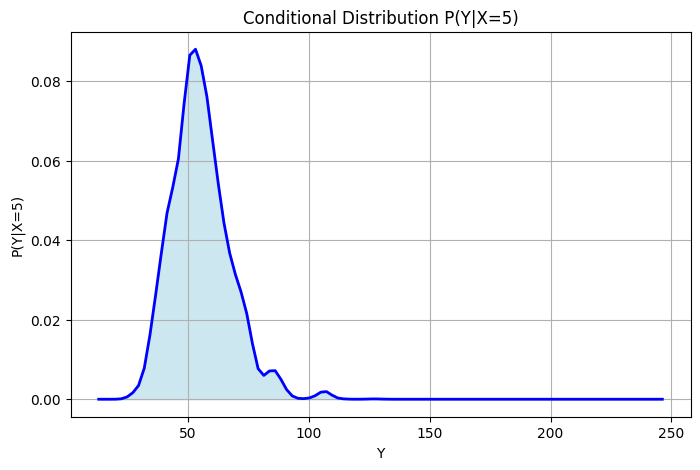

In [10]:

import matplotlib.pyplot as plt
import numpy as np

# Define your chosen X value
chosen_x = 5

# Find the closest index for chosen_x in xgrid
x_idx = np.abs(xgrid - chosen_x).argmin()

# Extract the joint density values at this X value
joint_density_at_x = normalized_density_values[:, x_idx]

# Calculate the marginal density for this X value (sum over Y)
marginal_density_x = np.sum(joint_density_at_x)

# Compute the conditional density P(Y|X)
conditional_density_y_given_x = joint_density_at_x / marginal_density_x

# Plot the conditional density with shaded area
plt.figure(figsize=(8, 5))
plt.fill_between(ygrid, conditional_density_y_given_x, color='lightblue', alpha=0.6)
plt.plot(ygrid, conditional_density_y_given_x, color='blue', linewidth=2)
plt.title(f'Conditional Distribution P(Y|X={chosen_x})')
plt.xlabel('Y')
plt.ylabel(f'P(Y|X={chosen_x})')
plt.grid(True)
plt.show()


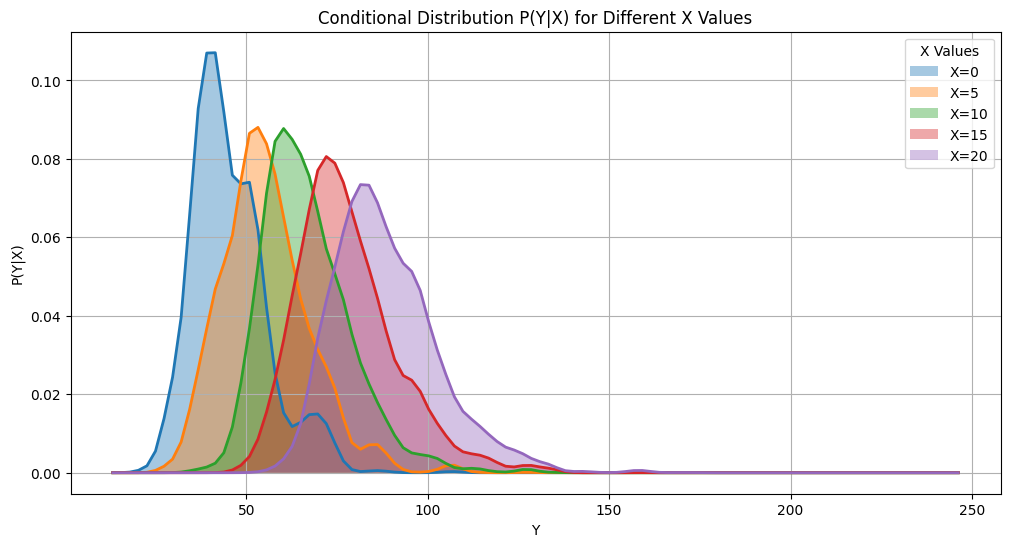

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of X values to consider (0, 5, 10)
x_values = np.arange(0, 21, 5)

# Create a plot for the conditional distributions
plt.figure(figsize=(12, 6))

# Loop through each chosen X value
for chosen_x in x_values:
    # Find the closest index for chosen_x in xgrid
    x_idx = np.abs(xgrid - chosen_x).argmin()

    # Extract the joint density values at this X value
    joint_density_at_x = normalized_density_values[:, x_idx]

    # Calculate the marginal density for this X value (sum over Y)
    marginal_density_x = np.sum(joint_density_at_x)

    # Compute the conditional density P(Y|X)
    conditional_density_y_given_x = joint_density_at_x / marginal_density_x

    # Plot the conditional density with a shaded area
    plt.fill_between(ygrid, conditional_density_y_given_x, alpha=0.4, label=f'X={chosen_x}')
    plt.plot(ygrid, conditional_density_y_given_x, linewidth=2)

# Add labels and legend
plt.title('Conditional Distribution P(Y|X) for Different X Values')
plt.xlabel('Y')
plt.ylabel('P(Y|X)')
plt.legend(title='X Values')
plt.grid(True)
plt.show()


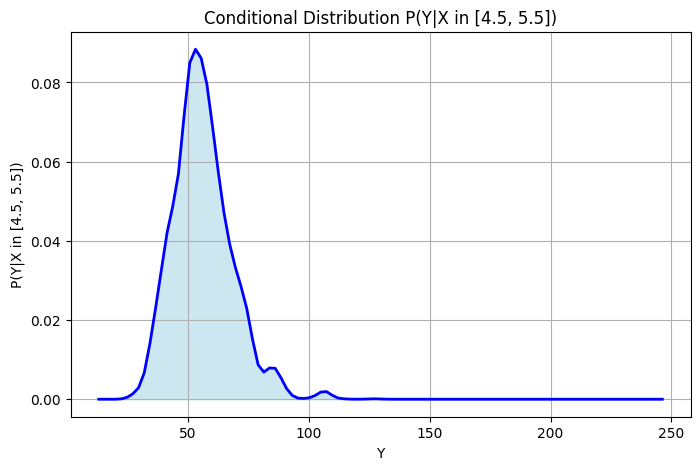

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range around the chosen X value
chosen_x = 5
range_width = 0.5
x_range = [chosen_x - range_width, chosen_x + range_width]

# Find indices in xgrid that correspond to this range
x_indices = np.where((xgrid >= x_range[0]) & (xgrid <= x_range[1]))[0]

# Extract and average the joint density values across this range
joint_density_at_x_range = np.mean(normalized_density_values[:, x_indices], axis=1)

# Calculate the marginal density for this range of X values (sum over Y)
marginal_density_x = np.sum(joint_density_at_x_range)

# Compute the conditional density P(Y|X in the chosen range)
conditional_density_y_given_x_range = joint_density_at_x_range / marginal_density_x

# Plot the conditional density with a shaded area
plt.figure(figsize=(8, 5))
plt.fill_between(ygrid, conditional_density_y_given_x_range, color='lightblue', alpha=0.6)
plt.plot(ygrid, conditional_density_y_given_x_range, color='blue', linewidth=2)
plt.title(f'Conditional Distribution P(Y|X in [{x_range[0]}, {x_range[1]}])')
plt.xlabel('Y')
plt.ylabel(f'P(Y|X in [{x_range[0]}, {x_range[1]}])')
plt.grid(True)
plt.show()


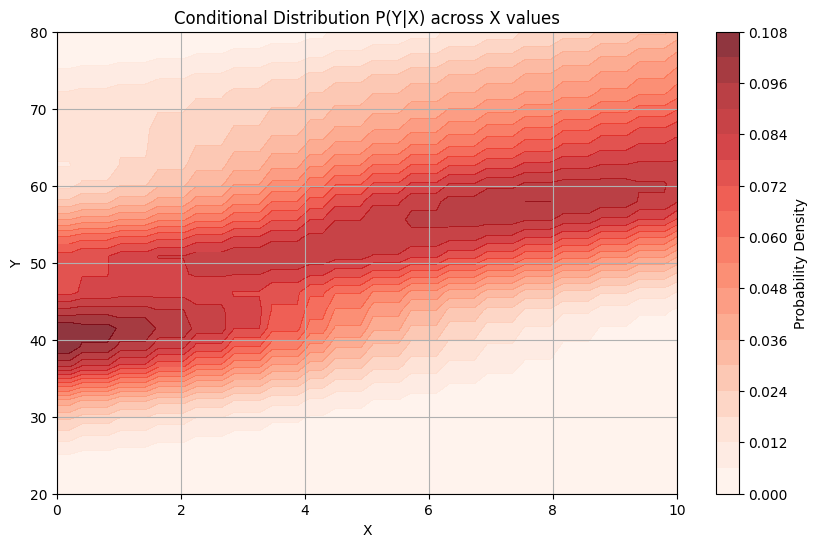

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the range of X values to consider
x_values = np.linspace(0, 10, 50)  # 50 points between 0 and 10

# Prepare an array to hold the conditional densities for each X value
conditional_densities = np.zeros((len(ygrid), len(x_values)))

# Loop through each chosen X value
for i, chosen_x in enumerate(x_values):
    # Find the closest index for chosen_x in xgrid
    x_idx = np.abs(xgrid - chosen_x).argmin()
    
    # Extract the joint density values at this X value
    joint_density_at_x = normalized_density_values[:, x_idx]
    
    # Calculate the marginal density for this X value (sum over Y)
    marginal_density_x = np.sum(joint_density_at_x)
    
    # Compute the conditional density P(Y|X)
    conditional_density_y_given_x = joint_density_at_x / marginal_density_x
    
    # Store the conditional density for this X value
    conditional_densities[:, i] = conditional_density_y_given_x

# Create a plot to show the conditional densities
plt.figure(figsize=(10, 6))
X, Y = np.meshgrid(x_values, ygrid)
plt.contourf(X, Y, conditional_densities, cmap='Reds', levels=20, alpha=0.8)
plt.colorbar(label='Probability Density')
plt.title('Conditional Distribution P(Y|X) across X values')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(20,80)
plt.grid(True)
plt.show()


(0.999, 1.001)

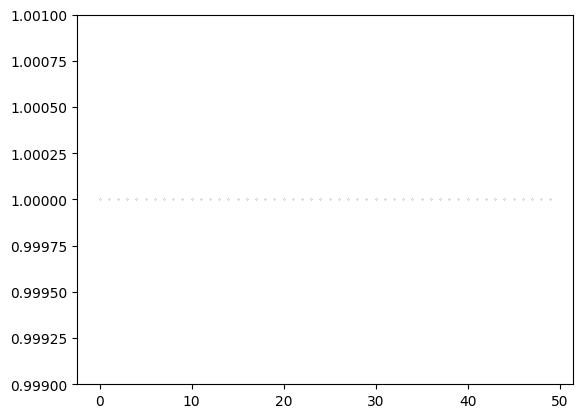

In [14]:
column_sums = np.sum(conditional_densities, axis=0)
plt.plot(column_sums,'.',markersize=.25,color='black')
plt.ylim(0.999, 1.001)

<div style="position: relative; width: 100%;">
    <hr style="position: absolute; left: 0; width: 50%; border: none; height: 2px; background-color: yellow; border-style: dotted;">
</div>
<span style="font-size: 12pt; color: blue; font-family: 'Times New Roman';"> SCRATCH </span>  

In [15]:
import numpy as np

def ptile(inDATA,percentile,axis):
    percentiles = np.percentile(inDATA, [percentile], axis=axis)
    # Find the row indices that are closest to the 17th percentiles for each column
    row_indices = np.argmin(np.abs(inDATA - percentiles), axis=axis)
    
    # Extract the values corresponding to these indices
    corresponding_values = inDATA[row_indices, np.arange(inDATA.shape[axis])]
    
    # Create a zero matrix with the same shape as inDATA
    result_matrix = np.zeros_like(inDATA)

    if axis == 0:
        # Assign the corresponding values to the result matrix
        result_matrix[row_indices, np.arange(inDATA.shape[1])] = inDATA[row_indices, np.arange(inDATA.shape[1])]
    else:
        # Assign the corresponding values to the result matrix for axis=1
        result_matrix[np.arange(inDATA.shape[0]), row_indices] = inDATA[np.arange(inDATA.shape[0]), row_indices]

    return percentiles, row_indices, result_matrix



In [16]:
p17, pos17,res17 = ptile(normalized_density_values, 17, 0)
p50, pos50,res50 = ptile(normalized_density_values, 50, 0)
p83, pos83,res83 = ptile(normalized_density_values, 83, 0)
p99, pos99,res99 = ptile(normalized_density_values, 99, 0)

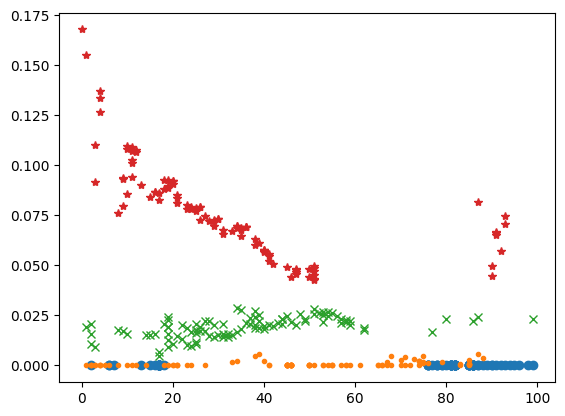

In [17]:
# xaxis = np.linspace(1, 100, 100)
plt.plot(np.squeeze(pos17),np.squeeze(p17),'o') 
plt.plot(np.squeeze(pos50),np.squeeze(p50),'.') 
plt.plot(np.squeeze(pos83),np.squeeze(p83),'x')
plt.plot(np.squeeze(pos99),np.squeeze(p99),'*') 
# plt.ylim(0.0999, 1.001)

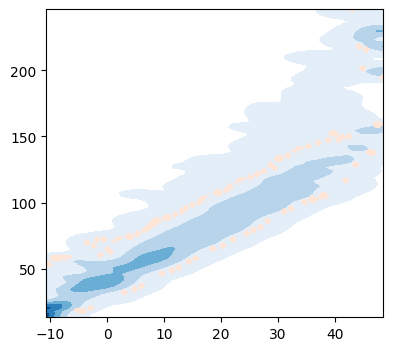

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
ax=axs[0]

clevels=np.linspace(0.001,0.2,6)
clabels=np.round(clevels,decimals=3).astype('str')
contour=ax.contourf(Xgrid, Ygrid, normalized_density_values,levels=clevels,cmap='Blues')
# contour=ax.contourf(Xgrid, Ygrid, res17,levels=clevels,cmap='Reds')
# contour=ax.contourf(Xgrid, Ygrid, res50,levels=clevels,cmap='Reds')
contour=ax.contourf(Xgrid, Ygrid, res83,levels=clevels,cmap='Reds')
# contour=ax.contour(Xgrid, Ygrid, res50,levels=clevels,colors='black')

## Add labels to the contour lines
ax.clabel(contour, inline=True, fontsize=2, fmt='%1.4f')


# remove other subaxis.
for i in [1, 2, 3]: axs[i].set_visible(False)